# Chinook Store Sales Business Analysis
In this analysis, I will be looking at some sample store data in the Chinook database to answer relevant business questions such as what genre of music sells the best. The analysis can inform the store on what albums to stock the store with and further analysis may explain trends in sales performance over time.

In [1]:
import sqlite3
import numpy as np
import pandas as pd

In [2]:
# Define a function to run a SQL query within a context manager
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [3]:
# Define a function to run a command within a context manager
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# Define a function to show tables within context
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Most Popular Genre of Music

In [6]:
# Query to return each genre, with number of tracks sold
albums_to_purchase = '''

WITH usa_tracks_sold AS
    (
    SELECT 
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id=il.invoice_id
    INNER JOIN customer c ON c.customer_id=i.customer_id
    WHERE c.country='USA'
    )
SELECT
    g.name AS genre,
    COUNT(uts.track_id) as number_of_tracks,
    cast(COUNT(uts.track_id) AS FLOAT)/ (SELECT COUNT(*) FROM usa_tracks_sold) AS percentage
    FROM usa_tracks_sold uts
    INNER JOIN track t ON uts.track_id=t.track_id
    INNER JOIN genre g ON g.genre_id=t.genre_id
    GROUP BY genre
    ORDER BY number_of_tracks DESC
    LIMIT 10
    
   
'''
run_query(albums_to_purchase)

,genre,number_of_tracks,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


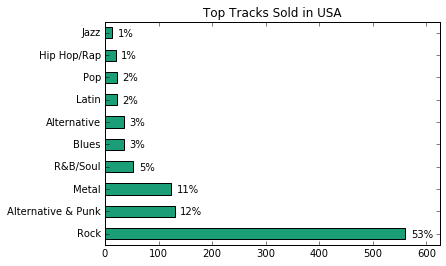

In [7]:
# Plot counts of tracks sold per genre as percentage
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)
genre_sales_usa["number_of_tracks"].plot.barh(
    title="Top Tracks Sold in USA",
    xlim = (0,625),
    colormap = plt.cm.Dark2
)
plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "number_of_tracks"]
    label = (genre_sales_usa.loc[label, "percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15)) # gives some white space for label

plt.show()

Based on the number of tracks sold in the USA, the most popular genres are Rock, Alternative & Punk, Metal, R&B, Blues. Pop is more popular than Hip-Hop. I would recommend selling Red Tone (Punk), Slim Jim Bites (Blues), and then Metoero

## Performance of Sales Support Agents
I'm interested in looking at how the sales support agents are performing in sales. To do that, I will sum up all the sales from different customers for each sales support agent.

In [8]:
# Query to find the total dollar amount of sales assigned to each sales support agent
support_agent_total_sales = '''

WITH total_sales AS
    (
    SELECT 
        c.customer_id AS customer,
        SUM(i.total) AS customer_sales,
        c.support_rep_id
    FROM invoice i
    INNER JOIN customer c ON c.customer_id=i.customer_id
    GROUP BY c.customer_id
    )
SELECT
    first_name || " " || last_name AS employee_name,
    ROUND(SUM(customer_sales),2) AS support_agent_sales,
    hire_date
    FROM total_sales t
    INNER JOIN employee e ON e.employee_id=t.support_rep_id
    WHERE title = 'Sales Support Agent'
    GROUP BY employee_name
    ORDER BY support_agent_sales DESC
    LIMIT 10
    
   
'''
run_query(support_agent_total_sales)

,employee_name,support_agent_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


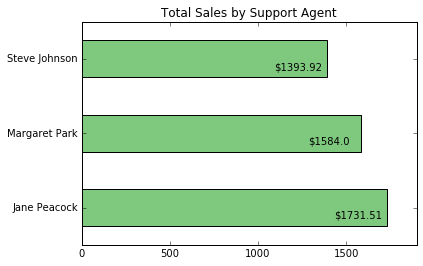

In [9]:
support_agent_sales = run_query(support_agent_total_sales)
support_agent_sales.set_index("employee_name", inplace=True, drop=True)
support_agent_sales.sort_values("support_agent_sales", ascending = False)
support_agent_sales["support_agent_sales"].plot.barh(
    title="Total Sales by Support Agent",
    xlim = (0,1900),
    colormap = plt.cm.Accent
)
plt.ylabel('')

for i, label in enumerate(list(support_agent_sales.index)):
    score = support_agent_sales.loc[label, "support_agent_sales"]
    plt.annotate("$" + str(score), (score - 300, i - 0.15))

plt.show()

Jane has the most sales, then Margaret, then Steve. The total dollar amount of sales is an absolute value that does not take into account the length of time the agents have been in sales. Further analysis could look into the amount of sales within a specified amount of time to compare sales performance equally across time.

## Country Sales Trends
I'm interested in looking into sales performance across different countries. As there are many countries, I will group all countries with only one customer into a single category, 'Other'.

In [10]:
# Query data that collates purchase data by country, calculate average value of sales per customer, and calculate average order value,
# The 'Other' country category has been forced to the bottom of the sorting

country_total_sales = '''

WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT
    country,
    number_of_customers,
    country_sales,
    customer_lifetime_value,
    average_order_value
FROM
(SELECT
    country,
    COUNT(distinct customer_id) as number_of_customers,
    ROUND(SUM(unit_price),2) AS country_sales,
    ROUND(SUM(unit_price)/COUNT(distinct customer_id),2) as customer_lifetime_value,
    ROUND(SUM(unit_price)/COUNT(distinct invoice_id),2) as average_order_value,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
    END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, country_sales DESC
    );   
   
'''
run_query(country_total_sales)

,country,number_of_customers,country_sales,customer_lifetime_value,average_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.58,8.72
9,Other,15,1094.94,73.00,7.45


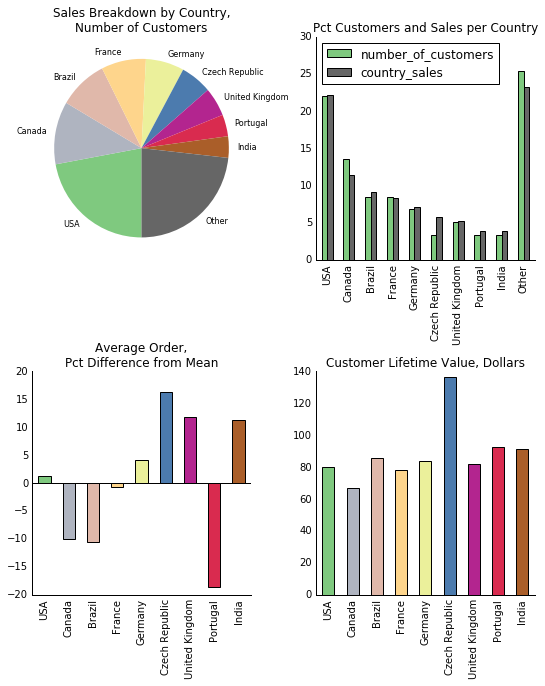

In [11]:
# Create visualizations for country metrics

country_metrics = run_query(country_total_sales)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["country_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["number_of_customers","country_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    title='Pct Customers and Sales per Country',
    colormap=plt.cm.Accent    
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
average_order=country_metrics["average_order_value"].copy()
average_order.index.name=''
difference_from_avg = average_order * 100 / average_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(True)

# bottom right
ltv=country_metrics["customer_lifetime_value"].copy()
ltv.index.name=''
ltv.drop("Other", inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.axhline(0, color='k')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(True)

plt.show()

Czech Republic, UK, and India seem to have higher orders than average and would be interesting to follow for growth potential. However, the sample size is quite small so this may not be representative. More data would be useful to make a better recommendation for marketing.

## Album versus Single Track Purchase
I'm interested in understanding the percentage of tracks that were purchased as part of an album and the percentage of tracks purchased as a single track. This could impact the purchasing strategy of the store from record companies but if there is a significant differenct, could impact the overall revenue.

To do this analysis, I will have to identify which invoice orders have all tracks from a single album, identifying that the track was purchased as part of an album.

Our strategy will be to compare the list of tracks from an invoice to a list of tracks on an album to see if the entire album was purchased. We can check if the exception of two subqueries is null to identify the invoices as album purchases.

In [12]:
# Query to categorize invoice as album purchase or single track
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases make up 20% of the store's sales. I would suggest against the trying the new strategy for buying only the popular tracks from albums as the store would lose 20% of the revenue.

## Most Popular Artist in Playlist
Next, I'll look into which artist is the most popularly used in playlists.

In [13]:
# Query for artist by number of playlists artist is in and genre
popular_artist = '''
WITH playlist_to_artist AS
    (
     SELECT
         a.name AS artist_name,
         COUNT(distinct p.playlist_id) AS number_of_playlists,
         g.name AS genre
     FROM track t
     INNER JOIN artist a ON a.artist_id=album.artist_id
     INNER JOIN album ON album.album_id=t.album_id
     INNER JOIN playlist_track pt ON pt.track_id=t.track_id
     INNER JOIN playlist p ON p.playlist_id=pt.playlist_id
     INNER JOIN genre g ON g.genre_id=t.genre_id
     GROUP BY artist_name
    )

SELECT
    artist_name,
    number_of_playlists,
    genre
FROM playlist_to_artist
GROUP BY artist_name
ORDER BY number_of_playlists DESC
LIMIT 10;
'''

run_query(popular_artist)

,artist_name,number_of_playlists,genre
0,Eugene Ormandy,7,Classical
1,Academy of St. Martin in the Fields & Sir Nevi...,6,Classical
2,Berliner Philharmoniker & Herbert Von Karajan,6,Classical
3,English Concert & Trevor Pinnock,6,Classical
4,The King's Singers,6,Classical
5,"Academy of St. Martin in the Fields, Sir Nevil...",5,Classical
6,Adrian Leaper & Doreen de Feis,5,Classical
7,Alberto Turco & Nova Schola Gregoriana,5,Classical
8,Antal Doráti & London Symphony Orchestra,5,Classical
9,Barry Wordsworth & BBC Concert Orchestra,5,Classical


Eugene Ormandy is the artist used i n the most playlists (7). It seems like classical tracks are on the most playlists.

In [14]:
# Query for all the playlists that Eugene Ormandy is in
popular_artist_playlists = '''

SELECT
    artist.name AS artist_name,
    p.playlist_id AS playlist_name,
    p.name
FROM track t
INNER JOIN album ON album.album_id=t.album_id
INNER JOIN artist ON artist.artist_id=album.artist_id
INNER JOIN playlist_track pt ON pt.track_id=t.track_id
INNER JOIN playlist p ON p.playlist_id=pt.playlist_id
WHERE artist_name="Eugene Ormandy"
GROUP BY playlist_name
;
'''

run_query(popular_artist_playlists)

,artist_name,playlist_name,name
0,Eugene Ormandy,1,Music
1,Eugene Ormandy,5,90’s Music
2,Eugene Ormandy,8,Music
3,Eugene Ormandy,12,Classical
4,Eugene Ormandy,13,Classical 101 - Deep Cuts
5,Eugene Ormandy,14,Classical 101 - Next Steps
6,Eugene Ormandy,15,Classical 101 - The Basics


## Percentage of tracks that have not been purchased
As a store with tracks ranging across multiple genres, it is important to know what tracks to stock and what tracks to get rid of. How many tracks have not been purchased?

In [22]:
# Query for the number of unpurchased tracks
unbought_tracks = '''
WITH purchased_tracks AS
    (
     SELECT
         il.track_id,
         COUNT(il.invoice_id) as number_of_invoices
     FROM invoice_line il
     GROUP BY track_id
    )

SELECT
    COUNT(t.track_id) AS unpurchased_tracks,
    CAST(COUNT(t.track_id) as FLOAT)/(SELECT COUNT(*) FROM track) AS percentage_unpurchased
FROM track t
LEFT JOIN purchased_tracks pt ON pt.track_id=t.track_id
WHERE number_of_invoices IS NULL

'''

run_query(unbought_tracks)

,unpurchased_tracks,percentage_unpurchased
0,1697,0.484442


It seems like the store may need to take an alternative approach to buying tracks from record companies as 48% of their inventory of tracks have never been purchased. Since they have been purchasing albums from record companies, this suggests that some of the tracks on albums never get purchased by customers and the popular songs on the albums are sold as single tracks. I would suggest that the store only purchase the tracks that are popular with customers and open up inventory for more classical tracks as well.